In [29]:
######## Global Imports #########
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange 
from tqdm import tqdm
from scipy.interpolate import make_interp_spline
import xlsxwriter
from scipy import stats

In [20]:
############################ CT -> Prev CT Data and Function ############################

# CONSTANTS
NO_KEYS = 256

################ Data #####################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

inv_sbox = [
   0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
   0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
   0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
   0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
   0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
   0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
   0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
   0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
   0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
   0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
   0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
   0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
   0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
   0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
   0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
   0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
]

sBox     = np.transpose(np.reshape(sbox, (16, 16))).flatten()
inv_sBox = np.reshape(inv_sbox, (16, 16)).flatten()
HW       = np.array([ bin(k).count("1") for k in np.arange(0,256) ]).astype(int).flatten()


############################ Functions ############################
def int_2_hex_string(input):
    return (("0x%0.2X" % input).split('x')[-1])


def sub_bytes(next):
    return sBox[next] 


def inv_sub_bytes(next: int) -> int:
    return inv_sBox[next] 
    

def add_round_key(key, next)-> int:
    return (key ^ next)


def generate_inverse_lookup_table():
    inverse_lookup_table = np.zeros((NO_KEYS,NO_KEYS))
    for key in range(NO_KEYS):
        for ct_8 in range(NO_KEYS):
            inverse_lookup_table[key, ct_8] = inv_sub_bytes(add_round_key(key, ct_8)) 
    return inverse_lookup_table.astype(int)


# Generate Inverse Lookup Table
INVERSE_LOOKUP_TABLE = generate_inverse_lookup_table()

# Inverse Mapping
CT_2_PREVCT_MAPPING = np.array([0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]).astype(int).flatten() 

In [21]:
############################ Forward and Reverse Key Expansion Functions ############################

from typing import List
from functools import reduce
from binascii import unhexlify, hexlify


rcon = [x.to_bytes(4, 'little') for x in [ 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36, ]]

def unhex(l: List[str]) -> List[bytes]:
    return [unhexlify(x) for x in l]

def xor_bytes(*arg: bytes) -> bytes:
    assert len({len(x) for x in arg}) == 1 # all args must have the same length
    xor_fun = lambda x, y : x ^ y
    return bytes(reduce(xor_fun, byt3s) for byt3s in zip(*arg)) 


def rot_word(word: bytes) -> bytes:
    '''
    apply the RotWord transformation to a bytes object of length 4
    '''
    assert len(word) == 4
    return bytes((word[(i + 1) % 4] for i in range(4)))


def sub_word(word: bytes) -> bytes:
    '''
    apply the AES S-Box to each of the bytes of the 4-byte word
    '''
    assert len(word) == 4
    return bytes((sbox[w] for w in word))


def key_schedule(base_key: bytes) -> List[bytes]:
    '''
    calculate the expanded AES key given the base key.
    Depending on the length of the base key 11, 13 or 15 round keys are returned
    for AES-128, AES-192 and AES-256 respectively.
    '''
    assert len(base_key) * 8 in {128, 192, 256}

    # length of the key in 32 bit words
    N = {128: 4, 192: 6, 256: 8}[len(base_key) * 8]

    # number of round keys needed
    R = {128: 11, 192: 13, 256: 15}[len(base_key) * 8]

    # the 32 bits words of the expanded key
    W = [None for _ in range(R * 4)]

    for i in range(N):
        W[i] = base_key[i * 4 : (i + 1) * 4]

    for i in range(N, 4 * R):
        if i % N == 0:
            W[i] = xor_bytes(W[i - N], sub_word(rot_word(W[i - 1])), rcon[i // N  - 1])
        elif N > 6 and i % N == 4:
            W[i] = xor_bytes(W[i - N], sub_word(W[i - 1]))
        else:
            W[i] = xor_bytes(W[i - N], W[i - 1])

    keys = [b''.join(W[i * 4 + j] for j in range(4)) for i in range(R)]
    return keys


def reverse_key_schedule(round_key: bytes, aes_round: int):
    '''
    reverse the AES-128 key schedule, using a single round_key.
    '''
    assert len(round_key) * 8 == 128
    for i in range(aes_round - 1, -1, -1):
        a2 = round_key[0:4]
        b2 = round_key[4:8]
        c2 = round_key[8:12]
        d2 = round_key[12:16]

        d1 = xor_bytes(d2, c2)
        c1 = xor_bytes(c2, b2)
        b1 = xor_bytes(b2, a2)
        a1 = xor_bytes(a2, rot_word(sub_word(d1)), rcon[i])

        round_key = a1 + b1 + c1 + d1

    return round_key

In [22]:
################### Data Loading Functions and Data Source Types ####################

### Data Source Types ###
import enum
class DataSource(enum.Enum):
    real    = 1
    lab_sim = 2
    own_sim = 3


############################ Data Loading Functions ############################
def get_power_from_raw_simulation(filename, trace_indx, no_points, points_per_trace, data_source):
    file = open(filename, "r")
    file_line_arr = file.readlines()
    
    pwr_trc = []
    begin   = trace_indx * points_per_trace
    end     = begin + no_points

    offset = 0
    if (data_source == 2):
        offset = 23
    elif (data_source == 3):
        offset = 21
    else:
        print("Invalid Data Source")  

    for i in range(begin, end):
        indx = (i*7) + offset
        pwr_trc.append( [float(file_line_arr[indx].strip('1'))] )

    file.close()
    return np.array(pwr_trc)


def get_power_from_real_data(filename):
    file = open(filename, "r")
    file_line_arr = file.readlines()
    
    pwr_trc = []
    for line in file_line_arr:
        pwr_trc.append( [ float(k) for k in line.split()] ) 

    file.close()
    return np.array(pwr_trc) 


def get_ct(filename, ct_indx, no_points, points_per_trace):
    file = open(filename, "r")
    file_line_arr = file.readlines()

    begin   = ct_indx * points_per_trace
    end     = begin + no_points

    ct_arr = []
    for ct in file_line_arr[begin:end]:
        temp  =  "".join(ct.split())
        temp2 = [temp[i:i+2] for i in range(0, len(temp), 2)]
        temp  = [int(k,16) for k in temp2]
        ct_arr.append(temp)

    file.close
    return np.array(ct_arr)


def get_keys(filename):
    file = open(filename, "r")
    file_line_arr = file.readlines()

    key_arr = []
    for ct in file_line_arr:
        temp  =  "".join(ct.split())
        temp2 = [temp[i:i+2] for i in range(0, len(temp), 2)]
        temp  = [int(k,16) for k in temp2]
        key_arr.append(temp)
    
    file.close
    return np.array(key_arr) 


In [23]:
############################ Key Recovery Evaluation Functions ############################

def success_rate_bit_wise(actual_key, recovered_key) -> float:
    temp_ac = ""
    temp_rc = ""
    for i in range(16):
        temp_ac += format(actual_key[i], "08b")
        temp_rc += format(recovered_key[i], "08b") 
    
    if (len(temp_ac) == len(temp_rc)):
        no_bits = len(temp_ac)
        cnt = 0
        for i in prange(no_bits):
            if temp_ac[i] == temp_rc[i]:
                cnt += 1
    
        return (cnt / no_bits) * 100

    return 0


def success_rate_byte_wise(actual_key, recovered_key) -> float:
    cnt = 0
    for i in prange(16):
        if(actual_key[i] == recovered_key[i]):
            cnt += 1
    return (cnt / 16) * 100


def success_rate_each_byte(actual_key, recovered_key, temp):
    for i in prange(16):
        if(actual_key[i] == recovered_key[i]):
            temp[i] += 1

In [24]:
############################ Statistics ############################

def mean(X):
    return np.mean(X,axis=0)

def sdev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2,axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar),axis=0)

In [25]:
############################ RUN CPA ATTACK (Implementation 1) ############################

@jit(nopython=True) 
def run_cpa_attack(power_leakage_points, cipher_texts, CT_2_PREVCT_MAPPING, INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS): 
    corr_coeffs_4all_bytes = np.zeros((16,NO_KEYS))
    
    for byte_num in range(0,16):
        corr_coeffs_4all_keys = np.zeros((1, NO_KEYS)).flatten()
        xor_byte_pos = CT_2_PREVCT_MAPPING[byte_num]

        for kguess in range(0, NO_KEYS):
            hws = np.zeros((1, NO_DATA)).flatten()
            corr_coeffs = np.zeros((1, NO_POINT_PER_TRACE)).flatten()  
            
            for trc_row in range(NO_DATA):
                op1 = INVERSE_LOOKUP_TABLE[kguess, cipher_texts[trc_row, byte_num]]
                op2 = cipher_texts[trc_row, xor_byte_pos]   
                hws[trc_row] = HW[op1 ^ op2] 
                #hws[trc_row] = np.abs(HW[op1] - HW[op2]) 


            # Hamming Weight Stats
            hws_bar = np.mean(hws)
            std_hws = np.sqrt(np.sum((hws-hws_bar)**2)) 
            
            # Prepare Hamming Distances and Power Trace for Calculations
            A = np.subtract(hws,hws_bar).reshape((-1,1)) 
            B = np.subtract(power_leakage_points, mean_power_trace) 

            # Covariance Calculation
            C = np.dot(B.transpose(), A) 

            # Correlation Coefficient Calculation
            D = np.multiply(sdev_power_trace, std_hws).reshape((-1,1))
            corr_coeffs = np.divide(C, D) 
            corr_coeffs_4all_keys[kguess] = np.amax(corr_coeffs)

        corr_coeffs_4all_bytes[byte_num] = corr_coeffs_4all_keys
    
    return corr_coeffs_4all_bytes

In [67]:
############################ RUN CPA ATTACK (Charles Spearman) ############################

@jit(nopython=True) 
def run_cpa_attack_spearman(power_leakage_points, cipher_texts, CT_2_PREVCT_MAPPING, INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS): 
    corr_coeffs_4all_bytes = np.zeros((16,NO_KEYS))
    
    for byte_num in range(0,16):
        corr_coeffs_4all_keys = np.zeros((1, NO_KEYS)).flatten()
        xor_byte_pos = CT_2_PREVCT_MAPPING[byte_num]

        for kguess in range(0, NO_KEYS):
            hws = np.zeros((1, NO_DATA)).flatten()
            
            for trc_row in range(NO_DATA):
                op1 = INVERSE_LOOKUP_TABLE[kguess, cipher_texts[trc_row, byte_num]]
                op2 = cipher_texts[trc_row, xor_byte_pos]   
                hws[trc_row] = HW[op1 ^ op2] 

            temp1 = np.argsort(power_leakage_points.flatten())
            rank1 = np.empty_like(temp1)
            rank1[temp1] = np.arange(len(power_leakage_points))

            temp2 = np.argsort(hws.flatten())
            rank2 = np.empty_like(temp2)
            rank2[temp2] = np.arange(len(hws))

            # Hamming Weight Stats
            rank1_bar = np.mean(rank1)
            rank1_std = np.sqrt(np.sum((rank1-rank1_bar)**2)) 

            rank2_bar = np.mean(rank2)
            rank2_std = np.sqrt(np.sum((rank2-rank2_bar)**2)) 

            # Prepare Hamming Distances and Power Trace for Calculations
            A = np.subtract(rank2,rank2_bar)
            B = np.subtract(rank1,rank1_bar) 

            # Covariance Calculation
            C = np.dot(B.transpose(), A) 

            # Correlation Coefficient Calculation
            D = np.multiply(rank1_std, rank2_std)
            corr_coeffs = np.divide(C, D) 
            corr_coeffs_4all_keys[kguess] = corr_coeffs

        corr_coeffs_4all_bytes[byte_num] = corr_coeffs_4all_keys
    
    return corr_coeffs_4all_bytes

In [27]:
############################ RUN CPA ATTACK (Implementation 2) ############################

@jit(nopython=True, parallel=True) 
def get_hamming_distances(cipher_texts,INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS):
    hamming_distances = np.zeros((16,NO_KEYS,NO_DATA))
            
    for trc_row in range(NO_DATA):
        ct = cipher_texts[trc_row,:].reshape(4,4).transpose()

        for byte_num in range(16):
            post_row = byte_num // 4
            post_col = byte_num % 4
            pre_row = post_row
            pre_col = post_col - post_row

            if (pre_col < 0):
                pre_col += 4
            
            byte_id = pre_col * 4 + pre_row
            op1     = ct[post_row, post_col]

            for kguess in range(NO_KEYS):
                pre_byte = ct[pre_row,pre_col] 
                op2 = INVERSE_LOOKUP_TABLE[kguess, pre_byte]
                hamming_distances[byte_id, kguess, trc_row] = HW[op1 ^ op2]
                #hamming_distances[byte_id, kguess, trc_row] = np.abs(HW[op1] - HW[op2])
                
    return hamming_distances


#@jit(parallel=True)
def get_key_bytes(pwr_trc, hamming_distances):
    pwr_mean = np.mean(pwr_trc) 
    pwr_sdev = np.sqrt(np.sum((pwr_trc-pwr_mean)**2)) 

    hd = hamming_distances.transpose() 
    hd_mean = np.mean(hd)
    hd_sdev = np.sqrt(np.sum((hd-hd_mean)**2, axis=0)).transpose().reshape((16,256))
    
    # Prepare Hamming Distances and Power Trace for Calculations
    A = np.subtract(hd.transpose(), hd_mean)
    B = np.subtract(pwr_trc, pwr_mean)

    # Covariance Calculation
    
    C = np.dot(A, B) 

    # Correlation Coefficient Calculation
    D = np.divide(C[:,:,0], np.multiply(hd_sdev, pwr_sdev))
    E = np.amax(D, axis=1) 

    keys = np.zeros((1,16)).flatten()
    for i in prange(16):
        keys[i] = np.where(D[i,:] == E[i])[0]
    
    return D, keys.astype(int)

In [68]:
### Setup Paramters ###
NO_TRACES    = 1000
step_size    = 100
NO_TEST_KEYS = 1
end          = int((NO_TRACES/step_size)) + 1
NO_DATA_ARR  = [10] + [(step_size*k) for k in range(1,end)]
data_source  = DataSource.own_sim
# print(NO_DATA_ARR)

###################### Attack on sim data for extracting success rates (bitwise and bytewise) ####################
success_per_no_data         = np.zeros((1,len(NO_DATA_ARR))).flatten()
success_per_no_data_2       = np.zeros((1,len(NO_DATA_ARR))).flatten()

if (data_source == DataSource.own_sim):
    all_power_trace  = get_power_from_raw_simulation("../data/simulation/aes_own/power_2000_100.out", 0, NO_TRACES*NO_TEST_KEYS, NO_TRACES,DataSource.own_sim.value)
    all_cipher_texts = get_ct("../data/simulation/aes_own/ct.txt", 0, NO_TRACES*NO_TEST_KEYS, NO_TRACES) 
elif (data_source == DataSource.lab_sim):
    all_power_trace  = get_power_from_raw_simulation("../data/simulation/aes_lab/power_5000_3.out", 0, 3, DataSource.lab_sim.value) 
    all_cipher_texts = get_ct("../data/simulation/aes_lab/55nm_5000_1.txt", NO_TRACES*NO_TEST_KEYS, NO_TRACES) 
elif(data_source == DataSource.real):
    all_power_trace  = get_power_from_real_data("../data/real/sumesh_data/data_x3000.txt") 
    all_cipher_texts = get_ct("../data/real/sumesh_data/ct_x3000.txt", 0, NO_TRACES, NO_TRACES)
else:
    print('No data or Invalid data source specified')
    exit

all_keys = get_keys("../data/simulation/aes_own/key.txt")

cnt = 0
for NO_DATA in tqdm(NO_DATA_ARR):
    recovery_rate   = 0
    recovery_rate_2 = 0

    for DATA_IDX in range(NO_TEST_KEYS):
        # Load Power and CipherText
        begin        = DATA_IDX*NO_TRACES
        end          = begin + NO_DATA
        power_trace  = all_power_trace[begin:end]
        cipher_texts = all_cipher_texts[begin:end]


        # Get Actual Key (for comparing later)
        actual_key_int  = all_keys[DATA_IDX]


        # Get Round 10 Key
        actual_key_str = ""
        for byte_no in range(0,16):
            actual_key_str  = actual_key_str + int_2_hex_string(actual_key_int[byte_no])
        actual_r10_key      = key_schedule( unhex([actual_key_str])[0] )
        actual_r10_key      = hexlify( actual_r10_key[10])
        actual_r10_key      = str(actual_r10_key, 'ascii').upper()
        actual_r10_key_int  = [actual_r10_key[i:i+2] for i in range(0, len(actual_r10_key), 2)]
        actual_r10_key_int  = [int(k,16) for k in actual_r10_key_int]


        # Select Power Leakage Point
        if (data_source == DataSource.real):
            NO_POINT_PER_TRACE      = power_trace[0].size
            round_size              = NO_POINT_PER_TRACE // 5
            trace_start             = NO_POINT_PER_TRACE - round_size
            power_leakage_points    = np.amin(power_trace[0:NO_DATA,trace_start:NO_POINT_PER_TRACE],axis=1).reshape((-1,1)) * -1
        else:
            power_leakage_points    = power_trace
        NO_POINT_PER_TRACE = power_leakage_points[0].size 


        # Get Statistics (Mean and Standard Deviation) of Power Traces
        mean_power_trace = mean(power_leakage_points)
        sdev_power_trace = sdev(power_leakage_points, mean_power_trace)


        # Call Attack Function
        corr_coeffs_4all_bytes  = run_cpa_attack_spearman(power_leakage_points, cipher_texts, CT_2_PREVCT_MAPPING, INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS) 

        # Extract Round 10 Key
        corr_coeffs_4all_bytes  = np.array(corr_coeffs_4all_bytes)
        found_r10_key_int       = []
        found_r10_key           = ""

        for byte_no in range(0,16):
            result = np.where(corr_coeffs_4all_bytes[byte_no] == np.amax(corr_coeffs_4all_bytes[byte_no]))
            found_r10_key_int.append(result[0][0])
            found_r10_key = found_r10_key + int_2_hex_string(result[0][0]) 

        # Reverse Key Expansion
        found_key = reverse_key_schedule(unhex([found_r10_key])[0], 10) 

        # Print Key

        #print("Actual Round 10 Key      : ", actual_r10_key) 
        #print("Recovered Round 10 Key   : ", found_r10_key) 

        #print("Actual Encryption Key    : ", actual_key_str.upper()) 
        #print("Recovered Encryption Key : ", str(hexlify(found_key), 'ascii').upper()) 


        key_recovery_rate   = success_rate_bit_wise(actual_r10_key_int, found_r10_key_int) 
        key_recovery_rate_2 = success_rate_byte_wise(actual_r10_key_int, found_r10_key_int)

        recovery_rate   += key_recovery_rate
        recovery_rate_2 += key_recovery_rate_2
    
    success_per_no_data[cnt]   = recovery_rate / NO_TEST_KEYS
    success_per_no_data_2[cnt] = recovery_rate_2 / NO_TEST_KEYS
    cnt += 1


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


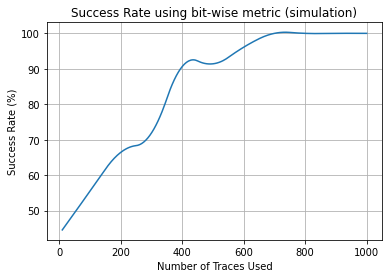

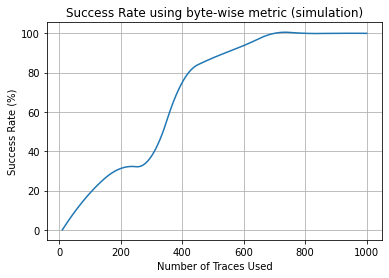

In [70]:
xnew = np.linspace(min(NO_DATA_ARR), max(NO_DATA_ARR), 300) 
spl = make_interp_spline(NO_DATA_ARR, success_per_no_data, k=2) 
smooth = spl(xnew)


plt.plot(xnew,smooth)
plt.xlabel("Number of Traces Used")
plt.ylabel("Success Rate (%)") 
plt.grid(axis='y')
plt.grid(axis='x')
plt.title("Success Rate using bit-wise metric (simulation)")
plt.show()

xnew = np.linspace(min(NO_DATA_ARR), max(NO_DATA_ARR), 300) 
spl = make_interp_spline(NO_DATA_ARR, success_per_no_data_2, k=2) 
smooth = spl(xnew)

plt.plot(xnew,smooth)
plt.xlabel("Number of Traces Used")
plt.ylabel("Success Rate (%)") 
plt.title("Success Rate using byte-wise metric (simulation)")
plt.grid(axis='y')
# plt.xscale('log')
plt.grid(axis='x')
plt.show()


In [ ]:
### Setup Parameters ###
NO_TRACES    = 2000
step_size    = 25
NO_TEST_KEYS = 5
end          = int((NO_TRACES/step_size)) + 1
NO_DATA_ARR  = [10] + [(step_size*k) for k in range(1,end)]
# print(NO_DATA_ARR)

############## Attack on simulation data for extracting success rates for each key byte ##############

each_byte_recovery_rate_arr = []

all_power_trace  = get_power_from_raw_simulation("../data/simulation/aes_own/power_2000_100.out", 0, NO_TRACES*NO_TEST_KEYS, NO_TRACES, DataSource.own_sim.value)
all_cipher_texts = get_ct("../data/simulation/aes_own/ct.txt", 0, NO_TRACES*NO_TEST_KEYS, NO_TRACES)
all_keys         = get_keys("../data/simulation/aes_own/key.txt")

for NO_DATA in tqdm(NO_DATA_ARR):
    each_byte_recovery_temp = np.zeros((1,16)).flatten() 

    for DATA_IDX in range(NO_TEST_KEYS):
        # Load Power and CipherText
        begin = DATA_IDX*NO_TRACES
        end   = begin + NO_DATA
        power_trace = all_power_trace[begin:end]
        cipher_texts = all_cipher_texts[begin:end]

        # Get Actual Key (for comparing later)
        actual_key_int  = all_keys[DATA_IDX]


        # Get Round 10 Key
        actual_key_str = ""
        for byte_no in range(0,16):
            actual_key_str  = actual_key_str + int_2_hex_string(actual_key_int[byte_no])
        actual_r10_key      = key_schedule( unhex([actual_key_str])[0] )
        actual_r10_key      = hexlify( actual_r10_key[10])
        actual_r10_key      = str(actual_r10_key, 'ascii').upper()
        actual_r10_key_int  = [actual_r10_key[i:i+2] for i in range(0, len(actual_r10_key), 2)]
        actual_r10_key_int  = [int(k,16) for k in actual_r10_key_int]

        power_leakage_points  = power_trace
        NO_POINT_PER_TRACE    = power_leakage_points[0].size 


        # Get Statistics (Mean and Standard Deviation) of Power Traces
        mean_power_trace = mean(power_leakage_points)
        sdev_power_trace = sdev(power_leakage_points, mean_power_trace)


        # Call Attack Function
        corr_coeffs_4all_bytes  = run_cpa_attack(power_leakage_points, cipher_texts, CT_2_PREVCT_MAPPING, INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS) 

        # Extract Round 10 Key
        corr_coeffs_4all_bytes  = np.array(corr_coeffs_4all_bytes)
        found_r10_key_int       = []
        found_r10_key           = ""

        for byte_no in range(0,16):
            result = np.where(corr_coeffs_4all_bytes[byte_no] == np.amax(corr_coeffs_4all_bytes[byte_no]))
            found_r10_key_int.append(result[0][0])
            found_r10_key = found_r10_key + int_2_hex_string(result[0][0]) 

        # Reverse Key Expansion
        found_key = reverse_key_schedule(unhex([found_r10_key])[0], 10) 

        success_rate_each_byte(actual_r10_key_int, found_r10_key_int, each_byte_recovery_temp) 
    
    each_byte_recovery_rate_arr.append(each_byte_recovery_temp) 

100%|██████████| 81/81 [00:41<00:00,  1.94it/s]


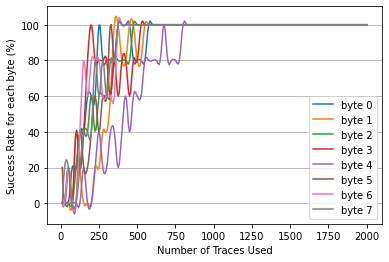

In [ ]:
############# Plotting KRSR for each key byte and saving the rates to an excel file ##############

each_byte_percentages = []

for i in range(16):
    temp_array = [] 
    for array in each_byte_recovery_rate_arr:
        temp_array.append( (array[i] / NO_TEST_KEYS) * 100 )  
    
    each_byte_percentages.append(temp_array) 

# Do (0,8) and then (8,16)
for i in range(0,8): 
    xnew = np.linspace(min(NO_DATA_ARR), max(NO_DATA_ARR), 300) 
    spl = make_interp_spline(NO_DATA_ARR, each_byte_percentages[i], k=2) 
    smooth = spl(xnew)
    plt.plot(xnew, smooth, label="byte "+str(i)) 

plt.xlabel("Number of Traces Used")
plt.ylabel("Success Rate for each byte (%)") 
plt.grid(axis='y')
plt.legend(loc="lower right") 
plt.show()

workbook = xlsxwriter.Workbook('percentage_per_byte_simulation.xlsx') 
worksheet = workbook.add_worksheet()
row = 0
for col, data in enumerate(each_byte_percentages):
    worksheet.write_column(row, col, data)
workbook.close()

In [73]:
### Setup Parameters ###
NO_TRACES       = 3000
step_size       = 50
end             = int((3000/step_size)) + 1
NO_DATA_ARR     = [10] + [(step_size*k) for k in range(1,end)]
#print(NO_DATA_ARR)

###################### Attack on real data for extracting success rates (bitwise and bytewise) ####################

byte_wise_recoveries = []
bit_wise_recoveries  = []

each_byte_recovery_rate_arr = [] 

all_power_trace  = get_power_from_real_data("../data/real/sumesh_data/data_x3000.txt")
all_cipher_texts = get_ct("../data/real/sumesh_data/ct_x3000.txt", 0, NO_TRACES, NO_TRACES)

cnt = 0
for NO_DATA in tqdm(NO_DATA_ARR):
    # Load Power and CipherText
    power_trace  = all_power_trace[0:NO_DATA]
    cipher_texts = all_cipher_texts[0:NO_DATA]

    # Get Actual Key (for comparing later)
    actual_key_int  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


    # Get Round 10 Key
    actual_key_str = ""
    for byte_no in range(0,16):
        actual_key_str  = actual_key_str + int_2_hex_string(actual_key_int[byte_no])
    
    #print(actual_key_str)

    actual_r10_key      = key_schedule( unhex([actual_key_str])[0] )
    actual_r10_key      = hexlify( actual_r10_key[10])
    actual_r10_key      = str(actual_r10_key, 'ascii').upper() 
    actual_r10_key_int  = [actual_r10_key[i:i+2] for i in range(0, len(actual_r10_key), 2)]
    actual_r10_key_int  = [int(k,16) for k in actual_r10_key_int]



    # Select Power Leakage Point
    NO_POINT_PER_TRACE      = power_trace[0].size
    round_size              = NO_POINT_PER_TRACE // 5
    trace_start             = NO_POINT_PER_TRACE - round_size
    power_leakage_points    = np.amin(power_trace[0:NO_DATA,trace_start:NO_POINT_PER_TRACE],axis=1).reshape((-1,1)) * -1

    NO_POINT_PER_TRACE      = power_leakage_points[0].size 


    # Get Statistics (Mean and Standard Deviation) of Power Traces
    mean_power_trace = mean(power_leakage_points)
    sdev_power_trace = sdev(power_leakage_points, mean_power_trace)


    # Call Attack Function
    corr_coeffs_4all_bytes  = run_cpa_attack_spearman(power_leakage_points, cipher_texts, CT_2_PREVCT_MAPPING, INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS) 

    # Extract Round 10 Key
    corr_coeffs_4all_bytes  = np.array(corr_coeffs_4all_bytes)
    found_r10_key_int       = []
    found_r10_key           = ""

    for byte_no in range(0,16):
        result = np.where(corr_coeffs_4all_bytes[byte_no] == np.amax(corr_coeffs_4all_bytes[byte_no]))
        found_r10_key_int.append(result[0][0])
        found_r10_key = found_r10_key + int_2_hex_string(result[0][0]) 

    # Reverse Key Expansion
    #found_key = reverse_key_schedule(unhex([found_r10_key])[0], 10) 

    key_recovery_rate   = success_rate_bit_wise(actual_r10_key_int, found_r10_key_int) 
    key_recovery_rate_2 = success_rate_byte_wise(actual_r10_key_int, found_r10_key_int)
    
    
    bit_wise_recoveries.append(key_recovery_rate)
    byte_wise_recoveries.append(key_recovery_rate_2)

100%|██████████| 61/61 [00:33<00:00,  1.84it/s]


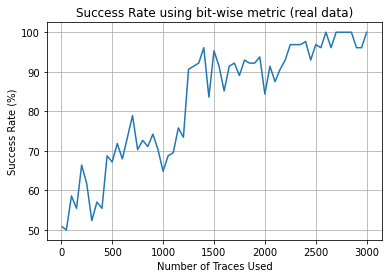

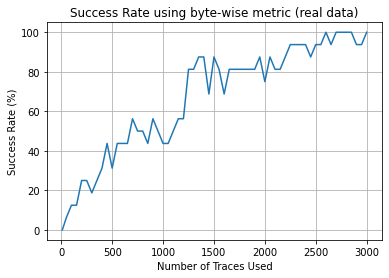

In [74]:
xnew = np.linspace(min(NO_DATA_ARR), max(NO_DATA_ARR), 300) 
spl = make_interp_spline(NO_DATA_ARR, bit_wise_recoveries, k=1) 
smooth = spl(xnew)


plt.plot(xnew,smooth)
plt.xlabel("Number of Traces Used")
plt.ylabel("Success Rate (%)") 
plt.grid(axis='y')
plt.grid(axis='x')
plt.title("Success Rate using bit-wise metric (real data)")
plt.show()

xnew = np.linspace(min(NO_DATA_ARR), max(NO_DATA_ARR), 300) 
spl = make_interp_spline(NO_DATA_ARR, byte_wise_recoveries, k=1) 
smooth = spl(xnew)

plt.plot(xnew,smooth)
plt.xlabel("Number of Traces Used")
plt.ylabel("Success Rate (%)") 
plt.title("Success Rate using byte-wise metric (real data)") 
plt.grid(axis='y')
# plt.xscale('log')
plt.grid(axis='x')
plt.show()

In [ ]:
# Get Key Using Implementation 2

hds = get_hamming_distances(cipher_texts, INVERSE_LOOKUP_TABLE, NO_DATA, NO_KEYS)
Corrs, key = get_key_bytes(power_leakage_points, hds)

found_r10_key = ""
for k in key:
    found_r10_key = found_r10_key + int_2_hex_string(k)

# Reverse Key Expansion
found_key = reverse_key_schedule(unhex([found_r10_key])[0], 10) 

# Print Key
print("Round 10 Key: ", found_r10_key) 
print("Encryption Key: ", hexlify(found_key))

Round 10 Key:  13111D7FE3944A17F307A78B4D2B30C5
Encryption Key:  b'000102030405060708090a0b0c0d0e0f'


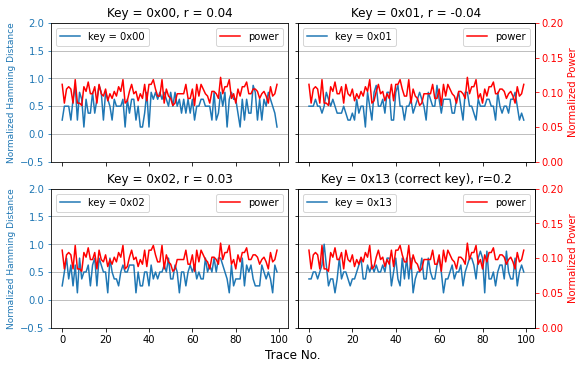

In [ ]:
byte_no   = 0
no_keys   = 2
no_points = 100

power_plot = np.abs( power_leakage_points[0:no_points] / np.linalg.norm(power_leakage_points[0:no_points]) )

fig, axs = plt.subplots(2, 2, figsize=(8, 5), constrained_layout=True,
                        sharex=True, sharey=True)

axs[0, 0].plot(hds[byte_no,0,0:no_points]/8, label="key = 0x00") 
axs[0, 0].set_title('Key = 0x00, r = ' + str(float('%.1g' % Corrs[byte_no,0])))
axs[0, 0].set_ylabel('Normalized Hamming Distance', color='tab:blue', fontsize=9) 
axs[0, 0].tick_params('y', colors='tab:blue')
ax0 = axs[0, 0].twinx()
ax0.plot(power_plot, 'r',label='power') 
ax0.legend(loc="upper right") 
ax0.set_ylim((0, 0.2))
ax0.axis('off')


axs[0, 1].plot(hds[byte_no,1,0:no_points]/8, label="key = 0x01") 
axs[0, 1].set_title('Key = 0x01, r = ' + str(float('%.1g' % Corrs[byte_no,1])))
ax1 = axs[0, 1].twinx()
ax1.plot(power_plot, color='r',label='power') 
ax1.legend(loc="upper right")
ax1.set_ylim((0, 0.2))
ax1.set_ylabel("Normalized Power", color='r')
ax1.tick_params('y', colors='r')

axs[1, 0].plot(hds[byte_no,2,0:no_points]/8, label="key = 0x02") 
axs[1, 0].set_title('Key = 0x02, r = ' + str(float('%.1g' % Corrs[byte_no,2])))
axs[1, 0].set_ylabel('Normalized Hamming Distance', color='tab:blue', fontsize=9) 
axs[1, 0].tick_params('y', colors='tab:blue')
ax2 = axs[1, 0].twinx()
ax2.plot(power_plot, 'r',label='power', ) 
ax2.legend(loc="upper right")
ax2.set_ylim((0, 0.2))
ax2.axis('off')

axs[1, 1].plot(hds[byte_no, found_r10_key_int[byte_no],0:no_points]/8, label="key = " + str(hex(found_r10_key_int[byte_no])))
strr = 'Key = '+str(hex(found_r10_key_int[byte_no])) + ' (correct key), r=' + str(float('%.1g' % Corrs[byte_no,found_r10_key_int[byte_no]]))
axs[1, 1].set_title(strr)
ax3 = axs[1, 1].twinx()
ax3.plot(power_plot, 'r',label='power', ) 
ax3.legend(loc="upper right")
ax3.set_ylim((0, 0.2))
ax3.set_ylabel("Normalized Power", color='r')
ax3.tick_params('y', colors='r')


fig.supxlabel("Trace No.") 

for ax in axs.flat:
    ax.grid(axis='y')
    ax.legend(loc="upper left") 
    ax.set_ylim((-0.5, 2))